In [1]:
from langchain_community.document_loaders import (
    UnstructuredHTMLLoader,
    BSHTMLLoader,
    TextLoader,
    JSONLoader,
)
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    MarkdownTextSplitter,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.vectorstores import Chroma
from langchain.chains import (
    RetrievalQA,
    ConversationalRetrievalChain,
    RetrievalQAWithSourcesChain,
)
from langchain.memory import ConversationBufferMemory
from langchain_community.llms import LlamaCpp
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import plot_example, score

import logging
import pickle


logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

## Helpers

In [20]:
retrieval_strategy = "mmr"
model = "llama-2-7b.Q3_K_M"

persist_directory = "./../embeddings"

In [3]:
def process_llm_response(llm_response):
    print("\n\nSources:")
    for i, source in enumerate(llm_response["source_documents"]):
        m = source.metadata
        print(f"{i + 1}. {m['course_title']} ({m['course_number']}): {m['heading']}")

In [4]:
class ResponseFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_response(self, llm_response, ground_truth):
        self.responses["question"].append(llm_response["query"])
        self.responses["contexts"].append(
            [doc.page_content for doc in llm_response["source_documents"]]
        )
        self.responses["answer"].append(llm_response["result"])
        self.responses["ground_truth"].append(ground_truth)

    def get_responses(self):
        return self.responses
    
    def get_dataframe(self):
        pd.DataFrame(self.responses[["question", "answer", "ground_truth"]])

## Vector Retriever

In [6]:
with open(f"{persist_directory}/embeddings.pickle", 'rb') as handle:
    embeddings = pickle.load(handle)


In [7]:
vectordb = Chroma(
    "documents", # or "transcripts"
    embedding_function=embeddings,
    persist_directory=persist_directory,
    collection_metadata={"hnsw:space": "cosine"},
)

In [8]:
retriever = vectordb.as_retriever(
    search_type=f"{retrieval_strategy}",
    search_kwargs={"k": 5, "fetch_k": 20},
)

## Quantized Model

In [9]:
llm_open = LlamaCpp(
    model_path=f"./../models/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
    n_ctx=4096,  # 4096 for Llama, 32*1024 for Mistral
    n_gpu_layers=50,
    temperature=0.15,
    top_p=1,
    top_k=40,
    repeat_penalty=1.1,
    max_tokens=1024,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    stream=True,
)

/Users/patrick/.local/share/virtualenvs/capstone-s4bMLJni/lib/python3.11/site-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! stream is not default parameter.
                stream was transferred to model_kwargs.
                Please confirm that stream is what you intended.
  warnings.warn(
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ./../models/llama-2-7b.Q3_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llam

In [10]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm_open,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
)

In [11]:
query = "Which class involves time series analysis?"

llm_response = qa_chain(query)
process_llm_response(llm_response)

/Users/patrick/.local/share/virtualenvs/capstone-s4bMLJni/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...
 Data Mining II (SIADS 632) and Learning Analytics and Educational Data Science (SIADS 680)



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      18.67 ms /    34 runs   (    0.55 ms per token,  1821.20 tokens per second)
llama_print_timings: prompt eval time =   34998.31 ms /   837 tokens (   41.81 ms per token,    23.92 tokens per second)
llama_print_timings:        eval time =    2811.16 ms /    33 runs   (   85.19 ms per token,    11.74 tokens per second)
llama_print_timings:       total time =   41203.32 ms /   870 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. Learning Analytics and Educational Data Science (SIADS 680): Student Services
3. Big Data: Scalable Data Processing (SIADS 516): Grading
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Math Methods I (SIADS 502): Course Schedule


## Run the Model

In [12]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    print(row["question"])

Which class involves time series analysis?
Who teaches the SQL and Databases class?
What are the prerequisites for Data Science for Social Good?
When are the office hours for the Math Methods course?
Are there any weekly readings for Milestone II?
What are the outcomes of Qualitative Inquiry?
What textbook is required for SIADS 505?
What textbook is required for Data Manipulation?
Which week of unsupervised learning covers DBSCAN?
How many credits are required to complete the MADS program?
How long do students have to complete the MADS program start to finish?
How many points is the comprehensive oral exam worth in SIADS 593?
What is the penalty for late submission in SIADS 630?
How do I get accommodations for a class?
What is a backpack?
When is the latest I can drop a course?
How do I get an override to take a class?
How do I take a leave of absence from the MADS program?
What are the prerequisites for Search and Recommender Systems?


In [13]:
formatter = ResponseFormatter()

# Or, use the cached one
# with open("./evaluation_set_formatter.pickle", 'rb') as handle:
#     formatter = pickle.load(handle)

In [14]:
for _, row in df.iterrows():
    llm_response = qa_chain(row["question"])
    process_llm_response(llm_response)

    formatter.add_response(llm_response, row["ground_truth"])

    # Save after each response in case this thing crashes
    with open(f"./cache/{retrieval_strategy}_{model}_formatter.pickle", 'wb') as handle:
        pickle.dump(formatter, handle)

    with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", 'wb') as handle:
        pickle.dump(formatter.get_responses(), handle)



> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 Data Manipulation and Visual Exploration of Data both involve time series analysis.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      33.27 ms /    19 runs   (    1.75 ms per token,   571.05 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =    9330.90 ms /    19 runs   (  491.10 ms per token,     2.04 tokens per second)
llama_print_timings:       total time =    9953.70 ms /    20 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. Learning Analytics and Educational Data Science (SIADS 680): Student Services
3. Big Data: Scalable Data Processing (SIADS 516): Grading
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Math Methods I (SIADS 502): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The instructor is Graham Hukill (gshukill@umich.edu). The course assistants are Derek Bruckner (dbrucknr@umich.edu), Emily Schemanske (landise@umich.edu), Jungseo Lee (jungseo@umich.edu), Toby Kemp (tobyk@umich.edu).



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      28.30 ms /    85 runs   (    0.33 ms per token,  3003.32 tokens per second)
llama_print_timings: prompt eval time =   17629.00 ms /   558 tokens (   31.59 ms per token,    31.65 tokens per second)
llama_print_timings:        eval time =   21456.36 ms /    84 runs   (  255.43 ms per token,     3.91 tokens per second)
llama_print_timings:       total time =   42218.92 ms /   642 tokens



> Finished chain.


Sources:
1. SQL and Databases (SIADS 511): Instructor And Course Assistants
2. SQL and Databases (SIADS 511): Course Outcomes
3. SQL and Databases (SIADS 511): Technology Requirements (Unique To This Course)
4. SQL and Databases (SIADS 511): Textbooks
5. SQL and Databases (SIADS 511): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 SIADS 630 and SIADS 631 are prerequisites for SIADS 688. SIADS 630 is a course on causal inference and SIADS 631 is a course on social science theory and behavioral economics.

Question: What are the prerequisites for Communicating Data Science Results?
Helpful Answer: SIADS 522 is a course on data visualization and SIADS 523 is a course on communicating data science results.

Question: What are the prerequisites for Data Science Ethics?
Helpful Answer: SIADS 503 is a course on data science ethics.

Question: What are the prerequisites for Data Science Ethics?
Helpful Answer: SIADS 503 is a course on data science ethics.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      68.53 ms /   197 runs   (    0.35 ms per token,  2874.49 tokens per second)
llama_print_timings: prompt eval time =   27464.45 ms /   812 tokens (   33.82 ms per token,    29.57 tokens per second)
llama_print_timings:        eval time =   42920.10 ms /   196 runs   (  218.98 ms per token,     4.57 tokens per second)
llama_print_timings:       total time =   77504.98 ms /  1008 tokens



> Finished chain.


Sources:
1. Data Science for Social Good (SIADS 688): Course Syllabus for SIADS 688: Data Science for Social Good Course Overview and Prerequisites
2. Data Science for Social Good (SIADS 688): Academic Integrity/Code of Conduct
3. Communicating Data Science Results (SIADS 523): Course Syllabus SIADS 523: Communicating Data Science Results (Fall 2023) Course Overview And Prerequisites
4. n/a (n/a): Academics > Master of Applied Data Science (MADS) > Summary of Degree Requirements
5. Data Science Ethics (SIADS 503): Course Learning Outcomes


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The office hours for Math Methods are on Wednesdays from 4-5pm EST and Fridays from 9-10am EST.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      17.01 ms /    35 runs   (    0.49 ms per token,  2057.86 tokens per second)
llama_print_timings: prompt eval time =   33248.11 ms /   878 tokens (   37.87 ms per token,    26.41 tokens per second)
llama_print_timings:        eval time =    6610.26 ms /    34 runs   (  194.42 ms per token,     5.14 tokens per second)
llama_print_timings:       total time =   42807.74 ms /   912 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Course Schedule
2. Unsupervised Learning (SIADS 543): Office Hours Schedule:
3. Experiment Design and Analysis (SIADS 631): Course Schedule
4. Causal Inference (SIADS 630): Office Hours:
5. Machine Learning Pipelines (SIADS 643): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 No, there are no weekly readings for Milestone II.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =       6.48 ms /    16 runs   (    0.41 ms per token,  2468.37 tokens per second)
llama_print_timings: prompt eval time =   31003.89 ms /   741 tokens (   41.84 ms per token,    23.90 tokens per second)
llama_print_timings:        eval time =    5369.12 ms /    15 runs   (  357.94 ms per token,     2.79 tokens per second)
llama_print_timings:       total time =   37930.76 ms /   756 tokens



> Finished chain.


Sources:
1. Milestone II (SIADS 696): Weekly Readings
2. Milestone II (SIADS 696): Project Component
3. Milestone I (SIADS 593): 6.0 Office Hours
4. Milestone II (SIADS 696): Re-Grade Policy
5. Milestone I (SIADS 593): 7.0 Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 Qualitative research is a methodology used in social sciences and humanities to collect and analyze non-numerical data. It is often used in conjunction with quantitative research methods to provide a more comprehensive understanding of a given topic or issue. Qualitative research can be used to explore the experiences and perspectives of individuals and groups, and to understand their motivations and behaviors. It can also be used to identify patterns and trends in social and cultural phenomena, and to develop theories and models that explain these patterns. Qualitative research can be used in a variety of fields, including sociology, anthropology, psychology, education, and healthcare. It can be used to study a wide range of topics, including social inequality, cultural differences, mental health, and healthcare access. Qualitative research can provide valuable insights into complex social and cultural issues and can help inform policy and practice in these areas.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =     126.11 ms /   191 runs   (    0.66 ms per token,  1514.61 tokens per second)
llama_print_timings: prompt eval time =   40498.36 ms /  1208 tokens (   33.53 ms per token,    29.83 tokens per second)
llama_print_timings:        eval time =   44501.50 ms /   191 runs   (  232.99 ms per token,     4.29 tokens per second)
llama_print_timings:       total time =  109734.41 ms /  1399 tokens



> Finished chain.


Sources:
1. Qualitative Inquiry for Data Scientists (SIADS 601): Learning Outcomes
2. Qualitative Inquiry for Data Scientists (SIADS 601): Course Handouts
3. Qualitative Inquiry for Data Scientists (SIADS 601): Grading And Assignments Overview
4. Experiment Design and Analysis (SIADS 631): Learning Outcomes
5. Causal Inference (SIADS 630): Accommodations


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 SIADS 505 does not require a textbook.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =       7.83 ms /    16 runs   (    0.49 ms per token,  2043.16 tokens per second)
llama_print_timings: prompt eval time =   11756.83 ms /   352 tokens (   33.40 ms per token,    29.94 tokens per second)
llama_print_timings:        eval time =    1585.53 ms /    16 runs   (   99.10 ms per token,    10.09 tokens per second)
llama_print_timings:       total time =   14430.97 ms /   368 tokens



> Finished chain.


Sources:
1. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
2. Applied Natural Language Processing (SIADS 655): Textbook Information
3. Presenting Uncertainty (SIADS 524): Required Textbook
4. Math Methods I (SIADS 502): Academic Integrity
5. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The textbook for Data Manipulation is _Storytelling with Data_ by Cole Nussbaumer Knaflic.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      15.71 ms /    29 runs   (    0.54 ms per token,  1845.49 tokens per second)
llama_print_timings: prompt eval time =   24931.44 ms /   647 tokens (   38.53 ms per token,    25.95 tokens per second)
llama_print_timings:        eval time =    5384.80 ms /    28 runs   (  192.31 ms per token,     5.20 tokens per second)
llama_print_timings:       total time =   33482.26 ms /   675 tokens



> Finished chain.


Sources:
1. Data Manipulation (SIADS 505): Course Syllabus Course Overview And Prerequisites
2. Communicating Data Science Results (SIADS 523): Required Textbook
3. Data Manipulation (SIADS 505): Library Access
4. Math Methods II (SIADS 602): Textbooks For Optional Readings
5. Health Analytics (SIADS 681): Weekly Readings or Textbook Information


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 Week 2.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =       4.74 ms /     6 runs   (    0.79 ms per token,  1266.62 tokens per second)
llama_print_timings: prompt eval time =   19262.42 ms /   470 tokens (   40.98 ms per token,    24.40 tokens per second)
llama_print_timings:        eval time =     430.07 ms /     5 runs   (   86.01 ms per token,    11.63 tokens per second)
llama_print_timings:       total time =   21255.06 ms /   475 tokens



> Finished chain.


Sources:
1. Unsupervised Learning (SIADS 543): Learning Outcomes: Week 2
2. SQL and Databases (SIADS 511): Course Schedule
3. Unsupervised Learning (SIADS 543): Schedule
4. Learning Analytics and Educational Data Science (SIADS 680): Office Hours Via Zoom (Ann Arbor, Michigan Time - Eastern Time Zone)
5. Unsupervised Learning (SIADS 543): Quizzes


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 To earn a Master of Applied Data Science degree from the University of Michigan School of Information, you must complete a minimum of 34 hours of graduate coursework, with a minimum cumulative grade average of B and a minimum grade of C- or greater in any course, including all required coursework.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      32.53 ms /    66 runs   (    0.49 ms per token,  2028.65 tokens per second)
llama_print_timings: prompt eval time =   41947.45 ms /  1012 tokens (   41.45 ms per token,    24.13 tokens per second)
llama_print_timings:        eval time =   11071.50 ms /    65 runs   (  170.33 ms per token,     5.87 tokens per second)
llama_print_timings:       total time =   60327.97 ms /  1077 tokens



> Finished chain.


Sources:
1. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
2. n/a (n/a): Course Planning > Q: What is the recommended number of credits students should take?
3. n/a (n/a): Course Planning > Q: When will courses be offered next?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. Unsupervised Learning (SIADS 543): Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 Per the [MADS Student Handbook](https://docs.google.com/document/d/1YEOcpdONdme5kmpNEnZpdbJeVFhEIw1pS0wq16QdH1I/edit?usp=sharing), "students are expected to complete all coursework within five years from the date of first enrollment in the program. Students exceeding this time limit must file a petition for modification or waiver of policy. Petitions must describe explicitly the amount of work remaining and a timeline for completion. Students must be making good progress and have good academic standing to receive an extension. A student who does not complete degree requirements within five years and does not petition for an extension may be withdrawn from the program and required to apply for readmission".


llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      87.83 ms /   182 runs   (    0.48 ms per token,  2072.18 tokens per second)
llama_print_timings: prompt eval time =   33024.27 ms /   957 tokens (   34.51 ms per token,    28.98 tokens per second)
llama_print_timings:        eval time =   35131.68 ms /   181 runs   (  194.10 ms per token,     5.15 tokens per second)
llama_print_timings:       total time =   82104.89 ms /  1138 tokens



> Finished chain.


Sources:
1. n/a (n/a): General Academic Advising > Q: How long do I have to complete the program?
2. n/a (n/a): Course Planning > Q: How are the MADS courses/semesters set up?
3. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Standards and Processes > Leaving Course Channels


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The comprehensive oral exam is worth 20% of your final grade in SIADS 593.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      11.11 ms /    27 runs   (    0.41 ms per token,  2430.24 tokens per second)
llama_print_timings: prompt eval time =   20284.40 ms /   532 tokens (   38.13 ms per token,    26.23 tokens per second)
llama_print_timings:        eval time =    5237.89 ms /    26 runs   (  201.46 ms per token,     4.96 tokens per second)
llama_print_timings:       total time =   28001.35 ms /   558 tokens



> Finished chain.


Sources:
1. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade
2. Milestone II (SIADS 696): Comprehensive Exam Component
3. Milestone I (SIADS 593): 4.0 Weekly Readings
4. Unsupervised Learning (SIADS 543): Quizzes
5. Information Visualization I (SIADS 522): Letter Grades, Course Grades, And Late Submission Policy


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The penalty for late submission in SIADS 630 is 15% daily-recurring reduction in grade for the first three days after the submission deadline. You will receive a zero (0) if your assignment is turned in four or more days late. Students have one free pass to submit all of one week's assessments late (up to three days). Students don't need to explain their circumstances but need to report their late submission by DMing Instructional team. Instructional team will adjust the late grade for one week's assessments.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      69.42 ms /   124 runs   (    0.56 ms per token,  1786.15 tokens per second)
llama_print_timings: prompt eval time =   38421.63 ms /   966 tokens (   39.77 ms per token,    25.14 tokens per second)
llama_print_timings:        eval time =   35241.31 ms /   123 runs   (  286.51 ms per token,     3.49 tokens per second)
llama_print_timings:       total time =   86210.09 ms /  1089 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Quizzes, Assignments, And Late Penalties
2. Capstone (SIADS 699): Late Submission Policy
3. Causal Inference (SIADS 630): Late Policy
4. Milestone II (SIADS 696): Late Submission Policy
5. Presenting Uncertainty (SIADS 524): Late Submissions


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 You should contact the instructor and/or academic advisor in the Office of Academic and Student Affairs in advance of the start of the term or as soon as possible thereafter. Requests for accommodations for exams, quizzes, or any other assignments or projects must be presented to the instructor at least two weeks before the due date. For any other event or services offered by UMSI for which you need accommodations, submit your request to the appropriate staff member at least two weeks in advance or at the time you register or RSVP if applicable. Because the decision to request reasonable accommodations due to a disability is a matter of individual choice, students have the responsibility to request reasonable accommodations in a timely manner. As a result, we do not assume that an accommodation provided in one course is appropriate or desired in another situation. Similarly, UMSI treats such requests in as confidential a manner as possible. Therefore, do not assume that because one fa


llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =     130.57 ms /   241 runs   (    0.54 ms per token,  1845.80 tokens per second)
llama_print_timings: prompt eval time =   31168.83 ms /   924 tokens (   33.73 ms per token,    29.65 tokens per second)
llama_print_timings:        eval time =   49209.35 ms /   240 runs   (  205.04 ms per token,     4.88 tokens per second)
llama_print_timings:       total time =   98805.79 ms /  1164 tokens



> Finished chain.


Sources:
1. n/a (n/a): Additional University Resources > Q: I need accommodations to best support my learning. Who can I talk to?
2. Data Science for Social Good (SIADS 688): Accommodations
3. n/a (n/a): Accommodations for Students with Disabilities Policy
4. n/a (n/a): Accommodations for Students with Disabilities Policy
5. Math Methods II (SIADS 602): Accommodations


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 A backpack is a type of bag that is worn on the back and has two straps that go over the shoulders and a zipper or other opening for access. Backpacks are often used for carrying books or other items while walking or hiking.


llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      33.84 ms /    55 runs   (    0.62 ms per token,  1625.06 tokens per second)
llama_print_timings: prompt eval time =   21761.39 ms /   568 tokens (   38.31 ms per token,    26.10 tokens per second)
llama_print_timings:        eval time =   15174.84 ms /    54 runs   (  281.02 ms per token,     3.56 tokens per second)
llama_print_timings:       total time =   42268.63 ms /   622 tokens



> Finished chain.


Sources:
1. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
2. Milestone II (SIADS 696): Technology Tips
3. Visual Exploration of Data (SIADS 521): Use Of External Resources And Services (E.G Chatgpt)
4. Visual Exploration of Data (SIADS 521): Accessibility
5. Learning Analytics and Educational Data Science (SIADS 680): Library Access


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The deadline to submit a request for a late drop (withdrawal) is 11:59pm on the last day of classes for each session.



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      16.18 ms /    36 runs   (    0.45 ms per token,  2225.52 tokens per second)
llama_print_timings: prompt eval time =   19338.09 ms /   587 tokens (   32.94 ms per token,    30.35 tokens per second)
llama_print_timings:        eval time =    6972.03 ms /    35 runs   (  199.20 ms per token,     5.02 tokens per second)
llama_print_timings:       total time =   29411.06 ms /   622 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What’s the latest that I can late drop a course?
2. n/a (n/a): Class Registration > Q: What do I need to do to drop a course during the add/drop period?
3. Deep Learning I (SIADS 642): Course Schedule
4. n/a (n/a): Course Planning > Q: When will courses be offered next?
5. n/a (n/a): Academics > Time Limit


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 You can get an override by emailing your instructor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailing your advisor and asking for one. You can also get an override by emailin


llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =     510.02 ms /  1024 runs   (    0.50 ms per token,  2007.78 tokens per second)
llama_print_timings: prompt eval time =   51657.32 ms /  1264 tokens (   40.87 ms per token,    24.47 tokens per second)
llama_print_timings:        eval time =  212835.49 ms /  1023 runs   (  208.05 ms per token,     4.81 tokens per second)
llama_print_timings:       total time =  334840.25 ms /  2287 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What is a Backpack?
2. n/a (n/a): Class Registration > Q: What’s the latest that I can late drop a course?
3. Social Media Analytics (SIADS 682): Content Warnings
4. Unsupervised Learning (SIADS 543): Grading And Course Checklist
5. n/a (n/a): Academics > Petition for Modification or Waiver of Policy


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 You can request a leave of absence by emailing [umsi.advising@umich.edu](mailto:umsi.advising@umich.edu). You will need to provide your name and UMID number and indicate if you are taking a leave for one or two terms. You will also need to indicate if you are taking a leave for medical reasons or other reasons.

Question: How do I withdraw from a class?
Helpful Answer: You can request a withdrawal from a class by emailing [umsi.advising@umich.edu](mailto:umsi.advising@umich.edu). You will need to provide your name and UMID number and indicate if you are withdrawing from one or two classes and which classes. You will also need to indicate if you are withdrawing for medical reasons or other reasons.

Question: How do I drop a class?
Helpful Answer: You can request a drop from a class by emailing [umsi.advising@umich.edu](mailto:umsi.advising@umich.edu). You will need to provide your name and UMID number and indicate if you are dropping one or two classes and which classes. You will also


llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =     520.27 ms /  1024 runs   (    0.51 ms per token,  1968.20 tokens per second)
llama_print_timings: prompt eval time =   48781.07 ms /  1269 tokens (   38.44 ms per token,    26.01 tokens per second)
llama_print_timings:        eval time =  225671.97 ms /  1023 runs   (  220.60 ms per token,     4.53 tokens per second)
llama_print_timings:       total time =  342308.54 ms /  2292 tokens



> Finished chain.


Sources:
1. n/a (n/a): Academics > Leave of Absence
2. n/a (n/a): Academics > Grades and Grading Policy > Grade of Incomplete (I)
3. n/a (n/a): Additional University Resources > Q: What mental health resources are available to MADS students?
4. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Practices > Acknowledge, even when you want to work on it later
5. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 SIADS 642: Deep learning, SIADS 652: Network analysis, SIADS 655: Applied NLP, SIADS 611: Database Architecture and Technology



llama_print_timings:        load time =    8666.75 ms
llama_print_timings:      sample time =      30.09 ms /    49 runs   (    0.61 ms per token,  1628.61 tokens per second)
llama_print_timings: prompt eval time =   28869.05 ms /   690 tokens (   41.84 ms per token,    23.90 tokens per second)
llama_print_timings:        eval time =   13731.99 ms /    48 runs   (  286.08 ms per token,     3.50 tokens per second)
llama_print_timings:       total time =   46979.58 ms /   738 tokens



> Finished chain.


Sources:
1. Search and Recommender Systems (SIADS 685): Course Overview And Prerequisites
2. Search and Recommender Systems (SIADS 685): Instructor And Course Assistants
3. Search and Recommender Systems (SIADS 685): Week 2: Retrieval Models, Web Search (Part I)
4. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
5. Data Science for Social Good (SIADS 688): Week 4 - Personalizing The Ask: Open Content, Recommender, And Reputation Systems


## Evaluation with BERTScore

In [21]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [22]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
 Data Manipulation and Visual Exploration of Data both involve time series analysis.



Who teaches the SQL and Databases class?
>>> The primary instructor for SQL and Databases is Graham Hukill. Additional course assistants include, Derek Bruckner, Emily Schemanske, Jungseo Lee, and Toby Kemp.
----------------------------------------------------------------------------------------------------
 The instructor is Graham Hukill (gshukill@umich.edu). The course assistants are Derek Bruckner (dbrucknr@umich.edu), Emily Schemanske (landise@umich.edu), Jungseo Lee (jungseo@umich.edu), Toby Kemp (tobyk@umich.edu).



What are the prerequisites for Data Science for Social Good?
>>> SIADS 630, 631, and 694
------------------------------------------------------------------

In [23]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    -1, # 'Which class involves time series analysis?',
    1, # 'Who teaches the SQL and Databases class?',
    -1, # 'What are the prerequisites for Data Science for Social Good?',
    -1, # 'When are the office hours for the Math Methods course?',
    1, # 'Are there any weekly readings for Milestone II?',
    -1, # 'What are the outcomes of Qualitative Inquiry?',
    -1, # 'What textbook is required for SIADS 505?',
    -1, # 'What textbook is required for Data Manipulation?',
    1, # 'Which week of unsupervised learning covers DBSCAN?',
    1, # 'How many credits are required to complete the MADS program?',
    1, # 'How long do students have to complete the MADS program start to finish?',
    -1, # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1, # 'What is the penalty for late submission in SIADS 630?',
    1, # 'How do I get accommodations for a class?',
    -1, # 'What is a backpack?',
    1, # 'When is the latest I can drop a course?',
    -1, # 'How do I get an override to take a class?',
    -1, # 'How do I take a leave of absence from the MADS program?',
    -1, # 'What are the prerequisites for Search and Recommender Systems?'
]

In [24]:
scores = [
    [
        t.item()
        for t in score(
            [rag_responses["answer"][i]],
            [rag_responses["ground_truth"][i]],
            rescale_with_baseline=True,
            lang="en",
        )
    ]
    for i in range(len(rag_responses["question"]))
]

with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "wb") as handle:
    pickle.dump(scores, handle)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [25]:
with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "rb") as handle:
    scores = pickle.load(handle)

bert_df = pd.concat(
    [
        responses_df,
        pd.DataFrame(scores, columns=["precision", "recall", "f1"]),
    ],
    axis="columns",
)

bert_df["abs_diff"] = (bert_df["eye_check"] - bert_df["f1"]).abs()

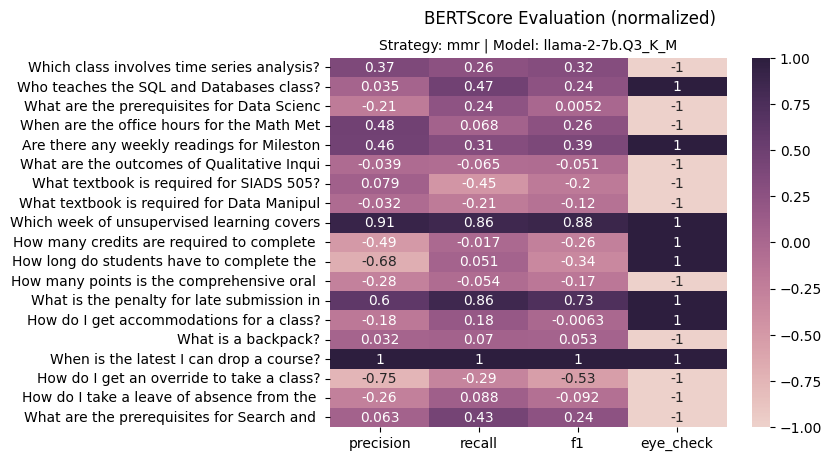

In [28]:
sns.heatmap(
    bert_df[["precision", "recall", "f1", "eye_check"]],
    yticklabels=bert_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("BERTScore Evaluation (normalized)")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()